In [ ]:
# setup for Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.0 MB/s 
     |████████████████████████████████| 120 kB 74.7 MB/s 
     |████████████████████████████████| 6.6 MB 34.9 MB/s 


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn

In [ ]:
root_dir = '/content/gdrive/MyDrive/oc_projet_7'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

torch.cuda.empty_cache()

cuda:0


## Get data

In [ ]:
test_mode = False
test_mode_samples = 1000

# load original df
data_path = root_dir + '/data/' + 'training.1600000.processed.noemoticon.csv'
column_names = ['label', 'id', 'date', 'flag', 'user', 'text']
to_keep = ['text', 'label']

df = pd.read_csv(data_path, encoding='latin-1', header=None, names=column_names)
if test_mode:
    # keep only a sample to increase computation speed
    df = df.sample(n=test_mode_samples, random_state=0)

df = df[to_keep]
df

,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,4
1599996,TheWDB.com - Very cool to hear old Walt interv...,4
1599997,Are you ready for your MoJo Makeover? Ask me f...,4
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4


## BERT on one tweet

In [ ]:
model_name = 'distilbert-base-uncased'
'''
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
'''
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
#sample_txt = "Replace me by any text you'd like."
sample_txt = df['text'].iloc[0]
tokens = tokenizer.tokenize(sample_txt)

print(sample_txt)
print(tokens)

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
['@', 'switch', '##foot', 'http', ':', '/', '/', 't', '##wi', '##tp', '##ic', '.', 'com', '/', '2', '##y', '##1', '##z', '##l', '-', 'aw', '##w', '##w', ',', 'that', "'", 's', 'a', 'bum', '##mer', '.', 'you', 'should', '##a', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', ';', 'd']


In [ ]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
token_ids

[1030,
 6942,
 13064,
 8299,
 1024,
 1013,
 1013,
 1056,
 9148,
 25856,
 2594,
 1012,
 4012,
 1013,
 1016,
 2100,
 2487,
 2480,
 2140,
 1011,
 22091,
 2860,
 2860,
 1010,
 2008,
 1005,
 1055,
 1037,
 26352,
 5017,
 1012,
 2017,
 2323,
 2050,
 2288,
 2585,
 12385,
 1997,
 2353,
 2154,
 2000,
 2079,
 2009,
 1012,
 1025,
 1040]

In [ ]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
df['nb_chars'] = df['text'].apply(len)
df['nb_chars'].describe()

count    1.600000e+06
mean     7.409011e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: nb_chars, dtype: float64

In [ ]:
df['nb_tokens'] = df['text'].apply(tokenizer.encode).apply(len)
df['nb_tokens'].describe()

count    1.600000e+06
mean     2.292560e+01
std      1.078172e+01
min      3.000000e+00
25%      1.400000e+01
50%      2.200000e+01
75%      3.100000e+01
max      2.300000e+02
Name: nb_tokens, dtype: float64

In [ ]:
df

,text,label,nb_chars,nb_tokens
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,115,48
1,is upset that he can't update his Facebook by ...,0,111,31
2,@Kenichan I dived many times for the ball. Man...,0,89,26
3,my whole body feels itchy and like its on fire,0,47,13
4,"@nationwideclass no, it's not behaving at all....",0,111,38
...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,4,56,14
1599996,TheWDB.com - Very cool to hear old Walt interv...,4,78,31
1599997,Are you ready for your MoJo Makeover? Ask me f...,4,57,15
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4,65,21


max nb characters =  374 



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


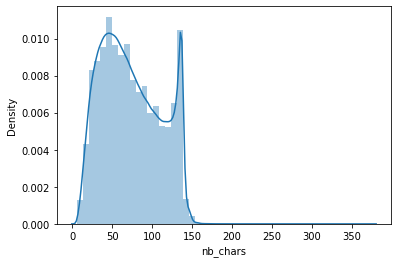




max nb tokens =  230 



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


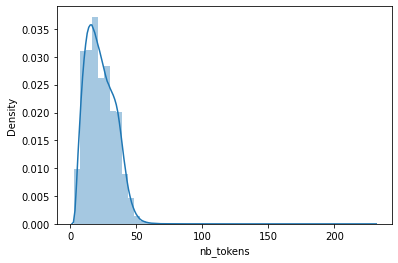

In [ ]:
max_nb_chars = df['nb_chars'].max()
print('max nb characters = ', max_nb_chars, '\n')
sns.distplot(df['nb_chars'])
plt.show()

print('\n'*2)

max_nb_tokens = df['nb_tokens'].max()
print('max nb tokens = ', df['nb_tokens'].max(), '\n')
sns.distplot(df['nb_tokens'])
plt.show()

In [ ]:
max_len = max_nb_tokens

In [ ]:
encoding = tokenizer.encode_plus(sample_txt, 
                                 max_length=max_len, 
                                 add_special_tokens=True, 
                                 padding='max_length', 
                                 return_attention_mask=True, 
                                 return_token_type_ids=False, 
                                 return_tensors='pt')

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding['input_ids']

tensor([[  101,  1030,  6942, 13064,  8299,  1024,  1013,  1013,  1056,  9148,
         25856,  2594,  1012,  4012,  1013,  1016,  2100,  2487,  2480,  2140,
          1011, 22091,  2860,  2860,  1010,  2008,  1005,  1055,  1037, 26352,
          5017,  1012,  2017,  2323,  2050,  2288,  2585, 12385,  1997,  2353,
          2154,  2000,  2079,  2009,  1012,  1025,  1040,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
from transformers import DistilBertModel
bert_model = DistilBertModel.from_pretrained(model_name)

print(bert_model)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [ ]:
bert_output = bert_model(encoding['input_ids'], 
                         attention_mask=encoding['attention_mask']
                         ).last_hidden_state

print(bert_output.shape)

torch.Size([1, 230, 768])


In [ ]:
f = nn.Flatten()
flat = f(bert_output)
print(flat.shape)

flattened_size = flat.shape[1]

torch.Size([1, 176640])


In [ ]:
print(bert_model.config.hidden_size)

768


## Create Dataset

In [ ]:
class_names = ['negative', 'positive']
nb_classes = len(class_names)
print(nb_classes)

2


In [ ]:
# convert labels: negative is 0, positive is 1
y_origin = np.array(df['label'])

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_origin)
print(le.classes_)

y = le.transform(y_origin)
print(np.unique(y))

[0 4]
[0 1]


In [ ]:
df['label'] = y
df

,text,label,nb_chars,nb_tokens
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,115,48
1,is upset that he can't update his Facebook by ...,0,111,31
2,@Kenichan I dived many times for the ball. Man...,0,89,26
3,my whole body feels itchy and like its on fire,0,47,13
4,"@nationwideclass no, it's not behaving at all....",0,111,38
...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,1,56,14
1599996,TheWDB.com - Very cool to hear old Walt interv...,1,78,31
1599997,Are you ready for your MoJo Makeover? Ask me f...,1,57,15
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1,65,21


In [ ]:
from torch.utils import data

class TweetDataset(data.Dataset):

    def __init__(self, tweet, target, tokenizer, max_len, nb_classes):
        self.tweet = tweet
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, item):
        tweet = str(self.tweet[item])

        encoding = tokenizer.encode_plus(tweet, 
                                         max_length=self.max_len, 
                                         add_special_tokens=True, 
                                         padding='max_length', 
                                         return_attention_mask=True, 
                                         return_token_type_ids=False, 
                                         return_tensors='pt'
                                        )

        return {'tweet_text': tweet, 
                'input_ids': encoding['input_ids'].flatten(), 
                'attention_mask': encoding['attention_mask'].flatten(), 
                'targets': torch.tensor(self.target[item], dtype=torch.long)
                }


In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_val_test = train_test_split(df, test_size=0.2, random_state=0)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=0)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1280000, 4)
(160000, 4)
(160000, 4)


In [ ]:
def make_data_loader(df, tokenizer, max_len, batch_size):
    dataset = TweetDataset(tweet=df['text'].to_numpy(), 
                           target=df['label'].to_numpy(), 
                           tokenizer=tokenizer, 
                           max_len=max_len, 
                           nb_classes=nb_classes)
    
    return data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
batch_size = 16

train_data_loader = make_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = make_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = make_data_loader(df_test, tokenizer, max_len, batch_size)

In [ ]:
# look at the first train batch for testing
batch = next(iter(train_data_loader))
batch.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(batch['input_ids'].shape)
print(batch['attention_mask'].shape)
print(batch['targets'].shape)

torch.Size([16, 230])
torch.Size([16, 230])
torch.Size([16])


## Create classifier

In [ ]:

from torch import nn

class Classifier(nn.Module):

    def __init__(self, nb_classes, max_nb_tokens):
        super(Classifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(model_name)
        self.flatten = nn.Flatten()
        fc_input_size = self.distilbert.config.hidden_size * max_nb_tokens
        self.fully_connected = nn.Linear(fc_input_size, nb_classes)
    
    def forward(self, input_ids, attention_mask):
        bert_output = self.distilbert(input_ids=input_ids, 
                                      attention_mask=attention_mask
                                      ).last_hidden_state
        bert_output_flattened = self.flatten(bert_output)
        classification_layer = self.fully_connected(bert_output_flattened)

        return classification_layer


In [ ]:
model = Classifier(nb_classes=nb_classes, max_nb_tokens=max_len)
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)

# raw output
output = model(input_ids, attention_mask)
print(output)

# output with softmax
print('\n')
print(nn.functional.softmax(output, dim=1))

tensor([[ 0.2868,  0.1259],
        [ 0.3644,  0.2677],
        [ 0.1752,  0.1975],
        [ 0.3549,  0.1651],
        [ 0.1990,  0.1725],
        [ 0.0674,  0.1588],
        [ 0.1000, -0.0685],
        [ 0.2147,  0.1442],
        [ 0.2735,  0.2889],
        [ 0.0022,  0.0847],
        [ 0.1901,  0.2088],
        [ 0.1595,  0.0817],
        [ 0.0796,  0.2069],
        [ 0.0273,  0.2706],
        [-0.0164, -0.0792],
        [ 0.2212,  0.1024]], device='cuda:0', grad_fn=<AddmmBackward0>)


tensor([[0.5401, 0.4599],
        [0.5242, 0.4758],
        [0.4944, 0.5056],
        [0.5473, 0.4527],
        [0.5066, 0.4934],
        [0.4772, 0.5228],
        [0.5420, 0.4580],
        [0.5176, 0.4824],
        [0.4961, 0.5039],
        [0.4794, 0.5206],
        [0.4953, 0.5047],
        [0.5194, 0.4806],
        [0.4682, 0.5318],
        [0.4395, 0.5605],
        [0.5157, 0.4843],
        [0.5297, 0.4703]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


## Training

In [ ]:
epochs = 3

In [ ]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=0.00002, correct_bias=False)

total_steps = len(train_data_loader) * epochs

from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

loss_func = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(model, 
                data_loader, 
                loss_func, 
                optimizer, 
                scheduler, 
                n_exemples, 
                device):
    
    model = model.train()
    
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_func(outputs, targets)
        correct_predictions += torch.sum(preds==targets).detach().cpu().numpy()
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)   # gradient clipping
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    accuracy = float(correct_predictions) / n_exemples
    mean_loss = np.mean(losses)
    return accuracy, mean_loss

In [ ]:
def eval_model(model, 
               data_loader, 
               loss_func, 
               n_exemples, 
               device):
    
    model = model.eval()
    
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_func(outputs, targets)
            correct_predictions += torch.sum(preds==targets).detach().cpu().numpy()
            losses.append(loss.item())

    accuracy = float(correct_predictions) / n_exemples
    mean_loss = np.mean(losses)
    return accuracy, mean_loss

In [ ]:
# with no training:
val_acc, val_loss = eval_model(model, 
                                val_data_loader, 
                                loss_func, 
                                len(df_val), 
                                device)

print('Prior to training:\n')
print(f'validation loss: {val_loss}, accuracy {val_acc}', '\n')

Prior to training:

validation loss: 0.6923550155758857, accuracy 0.51863125 



In [ ]:
%%time

from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
best_loss = 0

for epoch in range(epochs):
    print(f'epoch {epoch+1}/{epochs}')
    print('-'*10)

    train_acc, train_loss = train_epoch(model, 
                                        train_data_loader, 
                                        loss_func, 
                                        optimizer, 
                                        scheduler, 
                                        len(df_train), 
                                        device)
    print(f'     train loss: {train_loss}, accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, 
                                   val_data_loader, 
                                   loss_func, 
                                   len(df_val), 
                                   device)
    print(f'validation loss: {val_loss}, accuracy {val_acc}', '\n')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    '''
    if val_loss > best_loss:
        #torch.save(model, 'model.pth')
        best_accuracy = val_loss
    '''

    if not test_mode:
        i = 0
        model_path = root_dir + '/data/models/' + model_name + '_' + str(i) + '.pt'
        while os.path.exists(model_path):
            i += 1
            model_path = root_dir + '/data/models/' + model_name + '_' + str(i) + '.pt'
            model_weights_path = root_dir + '/data/models/' + model_name + '_weights_' + str(i) + '.pt'
        torch.save(model, model_path)
        torch.save(model.state_dict(), model_weights_path)
        


epoch 1/3
----------
     train loss: 0.3504767907267902, accuracy 0.8479515625
validation loss: 0.31602270779907704, accuracy 0.8655 

epoch 2/3
----------
     train loss: 0.284505918821058, accuracy 0.8837359375
validation loss: 0.3286759902736172, accuracy 0.8681875 

epoch 3/3
----------
     train loss: 0.23903321232050076, accuracy 0.9094828125
validation loss: 0.37426370395859704, accuracy 0.86830625 

CPU times: user 13h 45min 16s, sys: 47.7 s, total: 13h 46min 4s
Wall time: 13h 45min 23s


In [ ]:
save_model = False


if save_model:
    # choose model save path and save model
    i = 0
    model_path = root_dir + '/data/models/' + model_name + '_' + str(i) + '.pt'

    while os.path.exists(model_path):
        i += 1
        model_path = root_dir + '/data/models/' + model_name + '_' + str(i) + '.pt'

    print('model path:\n' + model_path + '\n')
    model_weights_path = root_dir + '/data/models/' + model_name + '_weights_' + str(i) + '.pt'

    torch.save(model, model_path)
    torch.save(model.state_dict(), model_weights_path)

    # load model
    model = Classifier(len(class_names), max_nb_tokens=max_len)
    model.load_state_dict(torch.load(model_weights_path))
    model = model.to(device)

model path:
/content/gdrive/MyDrive/oc_projet_7/data/models/distilbert-base-uncased_4.pt



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


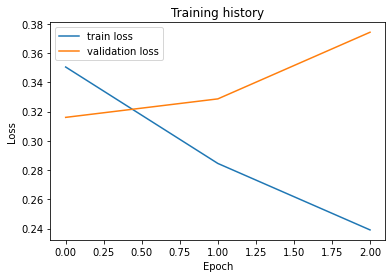

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

(0.0, 1.0)

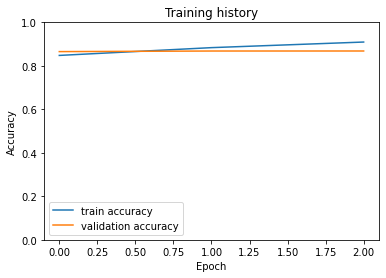

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

## Evaluation

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    tweet_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d['tweet_text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = nn.functional.softmax(outputs, dim=1)

            tweet_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()
        return tweet_texts, predictions, prediction_probs, real_values

In [ ]:
tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(model,
                                                            test_data_loader)

In [ ]:
# F-beta score on test set
beta = 2
from sklearn.metrics import fbeta_score
score = fbeta_score(y_test, y_pred, beta=beta)
print(f'F-{beta} score =', round(score, 3))

from sklearn.metrics import accuracy_score
print('accuracy =', round(accuracy_score(y_test, y_pred), 3))

F-2 score = 0.865
accuracy = 0.866


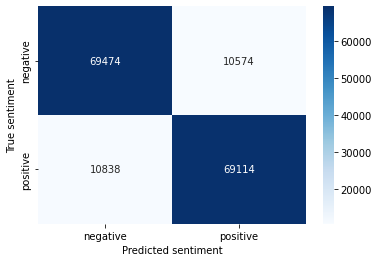

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels())
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels())
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 1

tweet_text = tweet_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({'class_names': class_names,
                        'values': y_pred_probs[idx]})

In [ ]:
from textwrap import wrap
print('\n'.join(wrap(tweet_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

@TPO_Hisself oooo...good one!  Gave my dad a bottle of that not too
long ago, mom wasn't amused!

True sentiment: positive


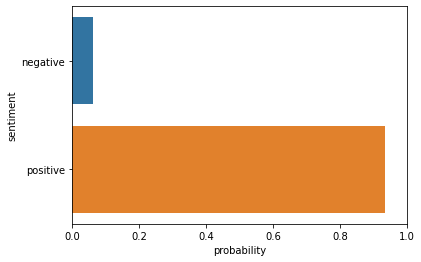

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

## Predict on one tweet:

In [ ]:
%%time

tweet = 'I am going to cry if this is not classified as negative...'

encoded_tweet = tokenizer.encode_plus(tweet, 
                                      max_length=max_len, 
                                      add_special_tokens=True, 
                                      padding='max_length', 
                                      return_attention_mask=True, 
                                      return_token_type_ids=False, 
                                      return_tensors='pt'
                                     )

input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
proba = nn.functional.softmax(output, dim=1)

print('Tweet :', tweet)
print('Sentiment :', class_names[prediction])
print('Probability :', float(torch.max(proba)))
print()

Tweet : I am going to cry if this is not classified as negative...
Sentiment : negative
Probability : 0.9986506104469299

CPU times: user 11.5 ms, sys: 8 ms, total: 19.5 ms
Wall time: 55.2 ms
